In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import src.model.flow_ot as fot
import src.model.ssl_ot as sot
import importlib 

### 1. Test for Semi-Supervised Training Vector Operations

In [ ]:
# set seed for reproducibility
np.random.seed(125)
# set array dimensions 
N = 4 # number of observations
M = 3 # dimension of an observation
K = 2 # number of classes
# simulate fake data
fake_y = np.random.randint(low = 0, high = 100, size = N * M * K).reshape((N * K, M))
fake_kern_y = np.random.randint(low = 0, high = 15, size = N * K * N * K).reshape((N * K, N * K))
fake_kern_z = np.random.randint(low = -10, high = 10, size = N * K * N * K).reshape((N * K, N * K))
fake_prob = np.random.randint(low = 0, high = 5, size = N * K).reshape((N, K))
fake_prob = (fake_prob.T / np.sum(fake_prob, axis = 1)).T # normalize

In [ ]:
# TODO: set the access data observation and class parameters
i = 1; k = 1;
# simulate "get_index" function 
l = i * K + k
print(f"The processed index is: {l}")
# reproduce gradient computation: the joint kernel derivative
print("\n\nCURRENTLY PROCESSING - joint kernels")
joint_prod = fake_kern_y[l, :] * fake_kern_z[l, :]
print(f"The product vectors on the (i={i}, k={k}) -> {l} entries are...", joint_prod)
weighted_diffs = (joint_prod * (fake_y[l, :] - fake_y).T).T
print(f"The weighted vector difference is\n", weighted_diffs)
summed_weights = np.sum(weighted_diffs, axis = 0)
print(f"Sum_weights:\n", summed_weights)
# check the summation of the kernel (i, k)s 
print(f"Sum of the kernel with respect to i, l: {np.sum(joint_prod)}")
# reproduce gradient computation: the singular kernel derivative 
print("\n\nCURRENTLY PROCESSING - singular y kernel")
weighted_diffs = (fake_kern_y[l, :] * (fake_y[l, :] - fake_y).T).T
print(f"The weighted vector difference is\n", weighted_diffs)

In [ ]:
print("CURRENTLY PROCESSING - probability weighted kernel")
weighted_kern_y = np.multiply(fake_prob.reshape((N * K, 1)), fake_kern_y)
print("Prob Weighted Kern:\n", weighted_kern_y)

In [ ]:
fake_prob[i, k] * np.sum(weighted_kern_y[l])

In [ ]:
(fake_prob[i, :] * (weighted_kern_y[i * K:(i + 1) * K]).T).T

In [ ]:
def estimate_p_ik(i, k, w_kern_y):
    l = i * K + k 
    return fake_prob[i, k] * np.sum(w_kern_y[l, :])

estimate_p_ik(i, k, weighted_kern_y) 

In [ ]:
lst = [estimate_p_ik(i, k_prime, weighted_kern_y) for k_prime in np.arange(K)]

In [ ]:
sum(lst)

### 2. Test using Simulation Data

In [16]:
# define a function to evaluate the classification accuracy
def eval(actual, predicted, mask): 
    unknown_actual = actual[mask]
    unknown_predicted = predicted[mask]
    return np.sum(unknown_actual == unknown_predicted) * 100 / len(unknown_actual)

In [95]:
# define a function to plot the kernel density estimation
def plot_densities(x_a, x_b, y_ssl, y = None): 
    """
    Visualize the kernel density estimations of the samples 
    from A, B, and the learned barycenter Y. 
    """
    _, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=x_a,
                color='crimson', label='A', fill=True, ax=ax)
    sns.kdeplot(data=x_b,
                color='limegreen', label='B', fill=True, ax=ax)
    if y is not None: 
        sns.kdeplot(data=y, color='purple', 
                    label='Y', fill=True, ax=ax)
    sns.kdeplot(data=y_ssl,
                color='aquamarine', label='Y_SSL', fill=True, ax=ax)
    ax.legend()
    plt.tight_layout()
    plt.show()
# generate samples from two 1-D gaussian distributions 
np.random.seed(125)
# set experiment parameters 
SAMPLE_SIZE = 10
NUM_CLASSES = 2
TOTAL_SIZE = NUM_CLASSES * SAMPLE_SIZE
MEAN_A = -1; SD_A = 1
MEAN_B = 1; SD_B = 1
# generate the x, labels, and y matrices 
x_a = np.random.normal(MEAN_A, SD_A, SAMPLE_SIZE)
x_b = np.random.normal(MEAN_B, SD_B, SAMPLE_SIZE)
x = np.concatenate((x_a, x_b)).reshape((TOTAL_SIZE, 1))
labels = np.zeros(TOTAL_SIZE, dtype=np.int64).reshape((TOTAL_SIZE, 1))
labels[SAMPLE_SIZE:] = 1
z_map = np.array([[0, 1], [1, 0]])

In [96]:
def run_experiment(ground_truth, percentage_masked): 
    num_masked = int(percentage_masked * TOTAL_SIZE)
    mask = np.random.choice(TOTAL_SIZE, num_masked, replace = False)
    # mark the masked elements as '-1'
    labels = np.copy(ground_truth)
    labels[mask] = -1
    # compute z 
    z = np.zeros((labels.shape[0], z_map.shape[1]))
    for i in range(z.shape[0]):
        z[i] = z_map[labels[i]]
    # set-up experiment parameters 
    LR_RATE = 0.01
    INIT_LAM = 50
    MAX_LAM = 500
    GROWING_LAM = True
    SIGMA_Z = 1
    SIGMA_Y = 1
    MAX_ITER = 5000
    WARM_STOP = 200 
    VERBOSE = 0
    EPSILON = 0.001
    Y_INIT = x
    MOCK_PROB = True
    ETA = 0.01
    DELAYED_PROB_UPDATE = True
    # reload library for the most updated versions 
    importlib.reload(sot)
    ssl = sot.SemiSupervisedOT(kernel_y_bandwidth=[SIGMA_Y], kernel_z_bandwidth=[SIGMA_Z])
    ssl.initialize(x, labels, NUM_CLASSES, z_map)
    y_ssl, assignments = ssl.train(Y_INIT, LR_RATE, EPSILON, MAX_ITER, GROWING_LAM, INIT_LAM, 
                                   WARM_STOP, MAX_LAM, MOCK_PROB, ETA, None, DELAYED_PROB_UPDATE, 
                                   VERBOSE, False)
    # y = fot.compute_barycenter(x, z, Y_INIT, INIT_LAM, 
    #                           epsilon=EPSILON, lr=LR_RATE, 
    #                           max_iter=MAX_ITER, verbose=VERBOSE,
    #                           growing_lambda=GROWING_LAM, warm_stop=WARM_STOP, 
    #                           max_lambda=MAX_LAM)
    plot_densities(x_a, x_b, y_ssl)
    accuracy = eval(ground_truth.flatten(), assignments.flatten(), mask.flatten())
    print(f"The classification accuracy is: {accuracy}% ")
    return ssl, y_ssl, assignments

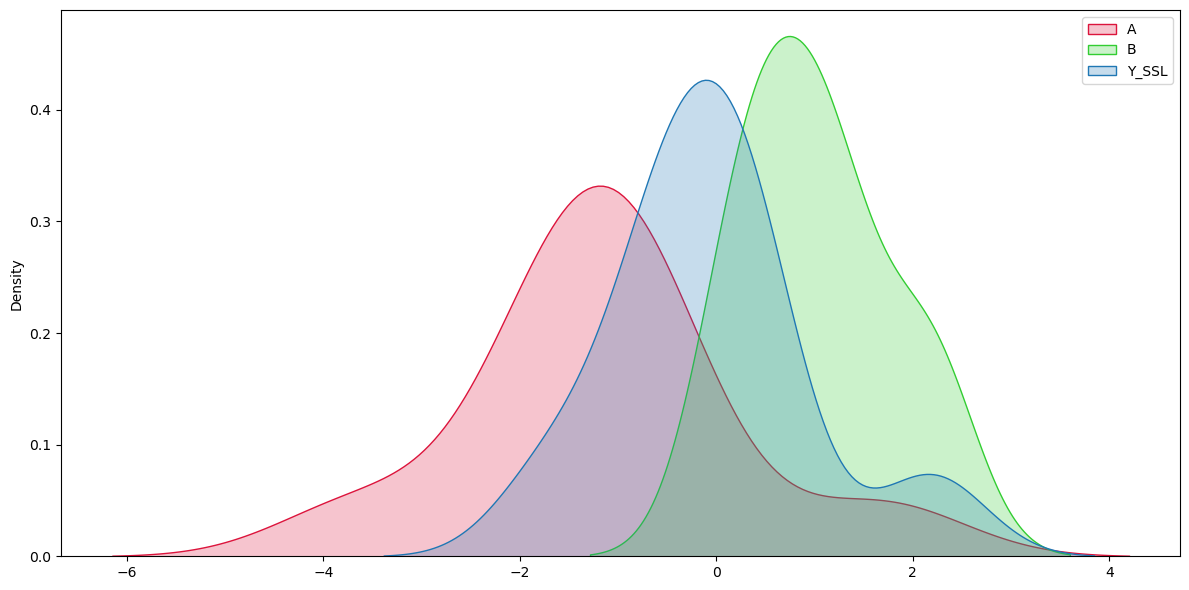

The classification accuracy is: 66.66666666666667% 


In [101]:
importlib.reload(sot)
model, y_ssl, predictions = run_experiment(labels, 0.3)

### 3. Evaluate Performance on Real Data

Iris Dataset

In [2]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
iris_data = load_iris()

In [3]:
# define a function to evaluate the classification accuracy
def eval(actual, predicted, mask): 
    unknown_actual = actual[mask]
    unknown_predicted = predicted[mask]
    return np.sum(unknown_actual == unknown_predicted) * 100 / len(unknown_actual)

In [4]:
SEED = 125
x = iris_data['data']
masked_labels, labels = sot.SemiSupervisedOT.mask(iris_data['target'], 0, SEED)
masked_subset = masked_labels == -1
num_classes = len(np.unique(labels))
z_map = np.eye(num_classes)

In [5]:
# run the semi-supervised barycenter solver with all labels known
ssl = sot.SemiSupervisedOT()
ssl.initialize(x, masked_labels, num_classes, z_map)
y, pred = ssl.train(x, lr=0.01, verbose = 1, max_lam = 500, max_iter = 5000, warm_stop = 500)

Iteration 100: gradient norm = 13.119472041204675
Iteration 200: gradient norm = 3.5129447612763633
Iteration 300: gradient norm = 1.4658379498400216
Iteration 400: gradient norm = 0.6869040646624549
Iteration 500: gradient norm = 0.36066522118039646
Iteration 600: gradient norm = 0.19638916268484
Iteration 700: gradient norm = 0.11387265189772386
Iteration 800: gradient norm = 0.06781854238028773
Iteration 900: gradient norm = 0.041070117096370484
Iteration 1000: gradient norm = 0.0251815334001023
Iteration 1100: gradient norm = 0.015607066699737257
Iteration 1200: gradient norm = 0.009774741942561537
Iteration 1300: gradient norm = 0.006188193927083515
Iteration 1400: gradient norm = 0.003962294239503885
Iteration 1500: gradient norm = 0.002567615416779035
Iteration 1600: gradient norm = 0.0016847806356889766
Iteration 1700: gradient norm = 0.001119720990673611
FINAL: Gradient norm = 0.0009969957517437463 at iteration 1729


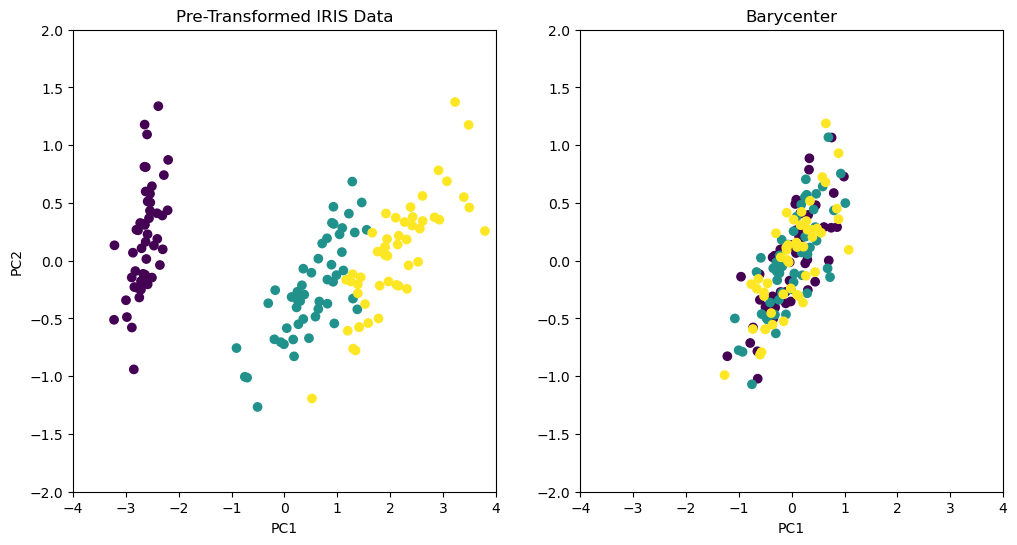

In [10]:
def iris_pca_vis(x, y, labels, mask=None): 
    """
    visualize the principle components of the pre-transformed iris data and 
    the resulting barycenter distribution. 
    """
    # fit the PCA model on the original data for ease of visualization
    pca = PCA(n_components=2)
    pca.fit(x)
    x_pca = pca.transform(x)
    # transform our barycenter points to sit on top of the same 
    # principle components as the original data
    y_pca = pca.transform(y)

    # plot the original data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.xlim(-4, 4)
    plt.ylim(-2, 2)
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=iris_data['target'])
    plt.title("Pre-Transformed IRIS Data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    # plot the barycenter
    plt.subplot(1, 2, 2)
    plt.xlim(-4, 4)
    plt.ylim(-2, 2)
    if mask is not None: 
        plt.scatter(y_pca[~mask, 0], y_pca[~mask, 1], c=labels[~mask])
        plt.scatter(y_pca[mask, 0], y_pca[mask, 1], c=labels[mask], edgecolors="red", linewidths=1)
    else: 
        plt.scatter(y_pca[:, 0], y_pca[:, 1], c=labels)
    plt.title("Barycenter")
    plt.xlabel("PC1")
    plt.show()

# mask = np.random.choice(x.shape[0], int(0.2 * x.shape[0]), replace = False)
iris_pca_vis(x, y, labels)

In [13]:
def run_iris_experiment(percentage_masked): 
    x = iris_data['data']
    masked_labels, ground_truth = sot.SemiSupervisedOT.mask(iris_data['target'], percentage_masked, SEED)
    masked_subset = masked_labels == -1
    num_classes = len(np.unique(ground_truth))
    z_map = np.eye(num_classes)
    # run the semi-supervised barycenter solver with some labels masked 
    ssl = sot.SemiSupervisedOT(kernel_y_bandwidth=[1 / (1 - percentage_masked)], 
                               kernel_z_bandwidth=[1 / (1 - percentage_masked)])
    ssl.initialize(x, masked_labels, num_classes, z_map)
    y, pred = ssl.train(x, lr = 0.005, max_iter = 10000, max_lam=800, 
                        warm_stop=500, eta = 0.001, mock_prob = True, 
                        delayed_prob_update = True, verbose = 1)
    # visualize the principle components of the pre-transformed iris data and the post-transformation 
    iris_pca_vis(x, y, ground_truth, masked_subset)
    # compute the classification accuracy
    accuracy = eval(ground_truth, pred, masked_subset)
    # train the KNN classifier on the original data
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x[~masked_subset], ground_truth[~masked_subset])
    # compute the classification accuracy of the KNN classifier
    knn_pred = knn.predict(x[masked_subset])
    knn_accuracy = accuracy_score(ground_truth[masked_subset], knn_pred) * 100
    print(f"The SOT classification accuracy is: {accuracy}% ")
    print(f"The KNN classification accuracy is: {knn_accuracy}% ")
    return ssl, y, pred

Iteration 100: gradient norm = 39.86833719177322
Iteration 200: gradient norm = 5.033649624090385
Iteration 300: gradient norm = 3.2113658191887877
Iteration 400: gradient norm = 2.155072764889375
Iteration 500: gradient norm = 1.5585010179482184
Iteration 600: gradient norm = 1.556036578332087
Iteration 700: gradient norm = 1.3968514981569602
Iteration 800: gradient norm = 1.2404333504770042
Iteration 900: gradient norm = 1.0954926254471453
Iteration 1000: gradient norm = 0.9675192985361325
Iteration 1100: gradient norm = 0.8615232714089535
Iteration 1200: gradient norm = 0.7769555660857792
Iteration 1300: gradient norm = 0.7111761596076123
Iteration 1400: gradient norm = 0.6617000605434098
Iteration 1500: gradient norm = 0.6251867360133516
Iteration 1600: gradient norm = 0.596006326686388
Iteration 1700: gradient norm = 0.5694832099332576
Iteration 1800: gradient norm = 0.5457803589329278
Iteration 1900: gradient norm = 0.5269340423563877
Iteration 2000: gradient norm = 0.51224308458

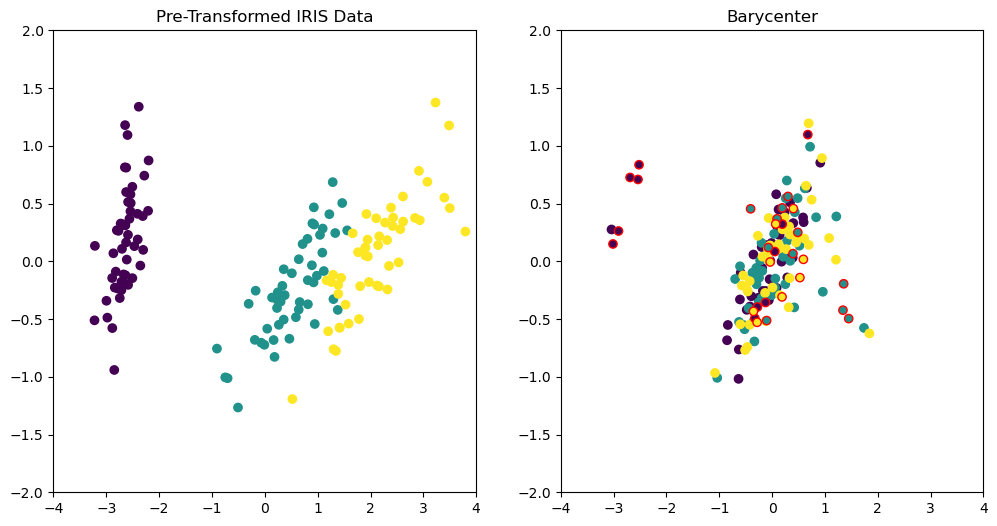

TypeError: globals must be a real dict; try eval(expr, {}, mapping)

In [14]:
ssl, y, pred = run_iris_experiment(0.2)